In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
from datetime import datetime
from datetime import timedelta
sns.set()

In [ ]:
## Save future files to your drive
## In this notebook control for multiple testing
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/FirmAI/FinML/Data/Stacked Trading"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/FirmAI/FinML/Data/Stacked Trading


In [ ]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("JPM", start="2018-01-01").reset_index()
df_full.to_csv('output/JPM.csv',index=False)
df_full.head()


[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,107.629997,108.019997,106.809998,107.949997,102.337044,13578800
1,2018-01-03,107.860001,108.489998,107.480003,108.059998,102.441338,11901000
2,2018-01-04,108.360001,110.029999,108.199997,109.040001,103.908867,12953700
3,2018-01-05,109.260002,109.550003,107.779999,108.339996,103.241798,14155000
4,2018-01-08,108.150002,108.680000,107.699997,108.500000,103.394272,12466500


In [ ]:
df_full = pd.read_csv('output/JPM.csv')

In [ ]:
# medium term instead of next day
# df_full["Adj Org"] = df_full["Adj Close"]
# df_full["Adj Close"] = df_full["Adj Close"].shift(-1)
# df_full = df_full[:-1]
df_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,107.629997,108.019997,106.809998,107.949997,102.337044,13578800
1,2018-01-03,107.860001,108.489998,107.480003,108.059998,102.441338,11901000
2,2018-01-04,108.360001,110.029999,108.199997,109.040001,103.908867,12953700
3,2018-01-05,109.260002,109.550003,107.779999,108.339996,103.241798,14155000
4,2018-01-08,108.150002,108.680000,107.699997,108.500000,103.394272,12466500


In [ ]:
## Encoder

import tensorflow as tf
import numpy as np
import time

def reducedimension(input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
    
    input_size = input_.shape[1]
    X = tf.placeholder("float", [None, input_size])
    
    weights = {
    'encoder_h1': tf.Variable(tf.random_normal([input_size, hidden_layer])),
    'encoder_h2': tf.Variable(tf.random_normal([hidden_layer, dimension])),
    'decoder_h1': tf.Variable(tf.random_normal([dimension, hidden_layer])),
    'decoder_h2': tf.Variable(tf.random_normal([hidden_layer, input_size])),
    }
    
    biases = {
    'encoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
    'encoder_b2': tf.Variable(tf.random_normal([dimension])),
    'decoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
    'decoder_b2': tf.Variable(tf.random_normal([input_size])),
    }
    
    first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(X, weights['encoder_h1']), biases['encoder_b1']))
    second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
    first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
    second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
    cost = tf.reduce_mean(tf.pow(X - second_layer_decoder, 2))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    for i in range(epoch):
        last_time = time.time()
        _, loss = sess.run([optimizer, cost], feed_dict={X: input_})
        if (i + 1) % 10 == 0:
            print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
        
    vectors = sess.run(second_layer_encoder, feed_dict={X: input_})
    tf.reset_default_graph()
    return vectors
  
## Model:


class Model:
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias = 0.1):
        
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(rnn_cells, output_keep_prob = forget_bias)
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
  
  

## Stacked Decision Tree Ensembles using XGBoost and Encoded Features (EXGBEF)

In [ ]:
df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,107.629997,108.019997,106.809998,107.949997,103.156837,13578800
1,2018-01-03,107.860001,108.489998,107.480003,108.059998,103.261963,11901000
2,2018-01-04,108.360001,110.029999,108.199997,109.040001,104.741249,12953700
3,2018-01-05,109.260002,109.550003,107.779999,108.339996,104.068840,14155000
4,2018-01-08,108.150002,108.680000,107.699997,108.500000,104.222534,12466500


In [ ]:
minmax = MinMaxScaler().fit(df.loc[:, "Adj Close"].values.reshape((-1,1)))
close_normalize = minmax.transform(df.loc[:, "Adj Close"].values.reshape((-1,1))).reshape((-1))

In [ ]:
close_normalize.shape

(381,)

In [ ]:
### Creating features through an encoder
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})

In [ ]:
tf.reset_default_graph()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.096642435 time: 0.0019376277923583984
epoch: 20 loss: 0.04476936 time: 0.004316091537475586
epoch: 30 loss: 0.037953585 time: 0.001964569091796875
epoch: 40 loss: 0.028800773 time: 0.001979351043701172
epoch: 50 loss: 0.018747538 time: 0.0019123554229736328
epoch: 60 loss: 0.010088451 time: 0.0018534660339355469
epoch: 70 loss: 0.005322166 time: 0.0017690658569335938
epoch: 80 loss: 0.13568221 time: 0.005709648132324219
epoch: 90 loss: 0.06659238 time: 0.0018053054809570312
epoch: 100 loss: 0.13453498 time: 0.0017628669738769531


(381, 32)

In [ ]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

In [ ]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

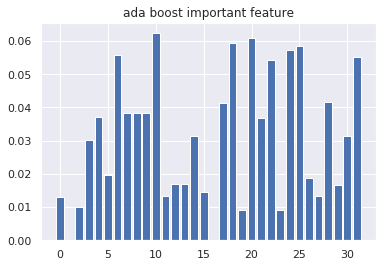

In [ ]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

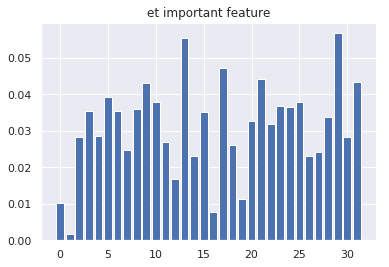

In [ ]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

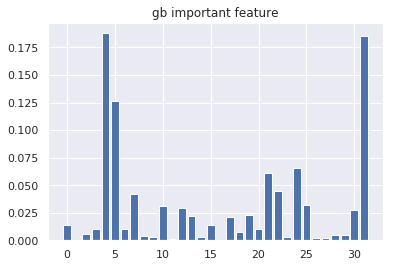

In [ ]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

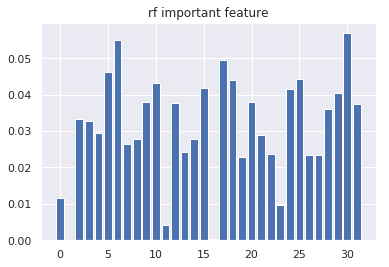

In [ ]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

In [ ]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

In [ ]:
ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,close_normalize]).T
corr_df = pd.DataFrame(stack_predict)

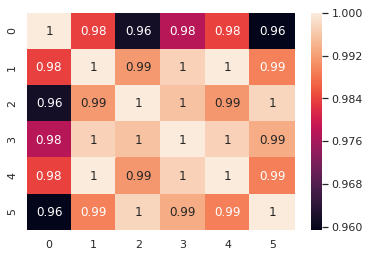

In [ ]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

### Stacking

In [ ]:
import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = close_normalize[1:]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[:-1,:],train_Y, eval_set=[(stack_predict[:-1,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_pred = clf.predict(stack_predict)
xgb_actual = np.hstack([close_normalize[0],xgb_pred[:-1]])
date_original=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

In [ ]:
clf.feature_importances_

array([0.00716003, 0.01782371, 0.06353572, 0.01811959, 0.03995783,
       0.85340315], dtype=float32)

In [ ]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

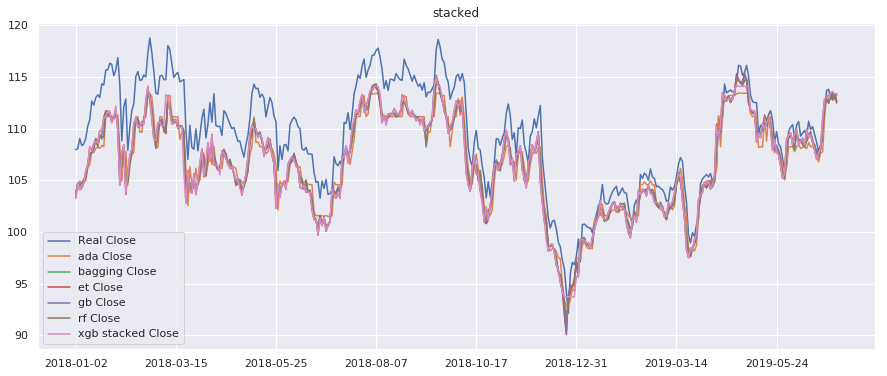

In [ ]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

In [ ]:
ada_list = ada_pred.tolist()
bagging_list = bagging_pred.tolist()
et_list = et_pred.tolist()
gb_list = gb_pred.tolist()
rf_list = rf_pred.tolist()
xgb_list = xgb_pred.tolist()
def predict(count, history = 5):
    for i in range(count):
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1,1)))
        ada_pred=ada.predict(thought_vector)
        bagging_pred=bagging.predict(thought_vector)
        et_pred=et.predict(thought_vector)
        gb_pred=gb.predict(thought_vector)
        rf_pred=rf.predict(thought_vector)
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagging_pred[-1])
        et_list.append(et_pred[-1])
        gb_list.append(gb_pred[-1])
        rf_list.append(rf_pred[-1])
        ada_actual = np.hstack([xgb_list[-history],ada_pred[:-1]])
        bagging_actual = np.hstack([xgb_list[-history],bagging_pred[:-1]])
        et_actual = np.hstack([xgb_list[-history],et_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-history],gb_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-history],rf_pred[:-1]])
        stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,xgb_list[-history:]]).T
        xgb_pred = clf.predict(stack_predict)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1]+timedelta(days=1))

In [ ]:
predict(30, history = 5)

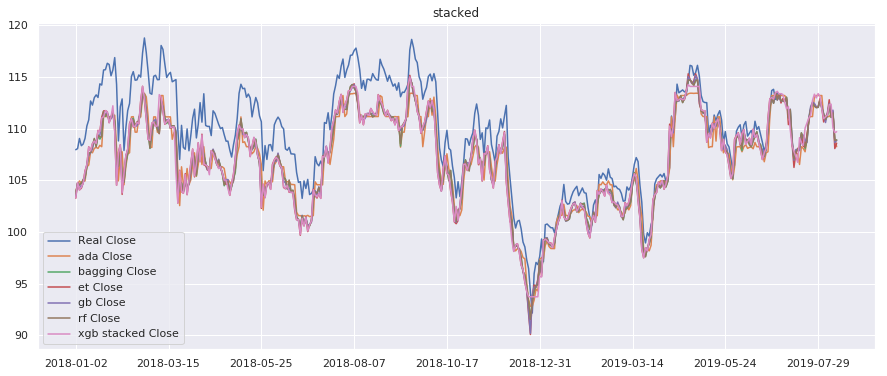

In [ ]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

## Stacked DFF NN Auto-Encoder with Deep RNN, ARIMA and XGBoost Regressor (DFNNARX)

### Our target is Close market

In [ ]:
import pandas_datareader.tsp as tsp
tspreader = tsp.TSPReader(start='2018-01-01')
d_fund = tspreader.read().iloc[:,:-1]
d_fund.head()

,L Income,L 2020,L 2030,L 2040,L 2050,G Fund,F Fund,C Fund,S Fund,I Fund
date,,,,,,,,,,
2018-01-02,19.5742,26.9502,30.8534,33.6297,19.4969,15.5426,18.0638,37.9236,48.8657,30.9194
2018-01-03,19.5945,26.9964,30.9419,33.7424,19.5702,15.5436,18.0849,38.1665,49.0288,30.9713
2018-01-04,19.6227,27.0634,31.0749,33.9132,19.6824,15.5446,18.0775,38.3284,49.1088,31.4317
2018-01-05,19.6467,27.1210,31.1901,34.0611,19.7797,15.5456,18.0599,38.5979,49.2932,31.6088
2018-01-08,19.6539,27.1346,31.2132,34.0900,19.7986,15.5486,18.0595,38.6626,49.4383,31.5810


In [ ]:
import pandas_datareader as pdr
### Add some additional variables

df_econ = pdr.fred.FredReader(["GDP","CPIAUCSL", "CPILFESL",'UEMPLT5','UEMP5TO14', 'UEMP15T26', 'UEMP27OV'], '2018-01-01')

df_econ = df_econ.read().ffill().bfill()
df_econ.index = df_econ.index.astype(str)
df_econ  = df_econ.rename(index={'2018-01-01': '2018-01-02'})
df_econ.index = pd.to_datetime(df_econ.index)


In [ ]:
df_capital  =pd.read_csv('input/capital_markets.txt')[1:] ### 130 additional series 

In [ ]:
df_capital  =df_capital.set_index('sasdate')

In [ ]:
df_capital.index = pd.to_datetime(df_capital.index)

In [ ]:
df_capital.index = df_capital.index.astype(str)
df_capital  = df_capital.rename(index={'2018-01-01': '2018-01-02'})

df_econ= pd.merge(df_econ,df_capital, left_index=True, right_index=True, how='left')

In [ ]:
df_econ.head()

,GDP,CPIAUCSL_x,CPILFESL,UEMPLT5_x,UEMP5TO14_x,UEMP15T26_x,UEMP27OV_x,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5_y,UEMP5TO14_y,UEMP15OV,UEMP15T26_y,UEMP27OV_y,CLAIMSx,PAYEMS,USGOOD,...,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXMMTH,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL_y,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,20163.159,248.884,255.218,2271.0,1927,959,1428,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.3440,99.4499,108.9284,105.0914,101.0844,103.3243,114.4532,110.2051,75.5478,6591.0,0.992471,161123.0,154482.0,4.1,23.9,2271.0,1927.0,2387.0,959.0,1428.0,235750.0,147767.0,20386.0,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.8710,1.3824,1.2429,202.2,214.9,196.7,200.8,63.70,204.3,248.884,125.799,208.926,481.246,184.040,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
2018-02-01,20163.159,249.369,255.662,2458.0,1900,933,1403,16099.220,13375.2,115.272,1471413.0,495393.0,106.6419,103.9057,102.3740,105.7831,122.2156,101.6298,99.3863,109.4661,106.5767,101.4496,104.4377,100.2431,108.2946,76.3398,6530.0,0.976522,161900.0,155213.0,4.1,22.9,2458.0,1900.0,2336.0,933.0,1403.0,219250.0,148097.0,20497.0,...,0.33,0.54,1.18,1.44,2.40,3.09,85.7143,0.9355,107.9700,1.3961,1.2588,202.3,214.9,197.9,203.4,62.23,205.0,249.369,127.338,209.493,481.083,184.179,104.423,313.607,248.923,230.846,238.247,107.556,87.992,99.304,113.842,23.72,27.41,21.34,99.7,15306.1,304665.80,736073.92,3396.2657,20.2578
2018-03-01,20163.159,249.498,256.144,2266.0,1976,900,1337,16154.764,13418.4,115.926,1478892.0,495668.0,107.2519,104.1306,102.7157,106.1346,122.6509,101.9594,99.5611,110.5458,106.7978,102.4747,104.4607,107.7060,109.9539,76.3293,6894.0,1.062905,161646.0,155160.0,4.0,24.2,2266.0,1976.0,2237.0,900.0,1337.0,222800.0,148279.0,20527.0,...,0.36,0.55,1.12,1.33,2.36,3.13,86.2362,0.9480,106.0468,1.3976,1.2933,203.0,215.9,198.0,196.4,62.73,202.9,249.498,126.661,208.353,482.495,183.701,104.468,314.319,249.024,230.635,238.315,107.610,87.911,98.743,114.135,23.76,27.40,21.39,101.4,15359.3,301911.41,730477.90,3382.0281,18.1940
2018-04-01,20510.177,249.956,256.420,2121.0,1975,1018,1311,16144.705,13401.4,116.284,1480268.0,497642.0,108.2223,105.1458,103.8951,107.4649,121.9159,103.7974,100.2015,111.4600,107.3540,103.4586,104.9102,118.8069,110.2517,76.6254,7106.0,1.121705,161551.0,155216.0,3.9,23.0,2121.0,1975.0,2330.0,1018.0,1311.0,219250.0,148475.0,20587.0,...,0.24,0.46,1.01,1.18,2.16,2.98,86.3533,0.9687,107.6562,1.4079,1.2732,202.8,215.4,198.9,198.3,66.25,205.5,249.956,126.682,208.535,483.183,184.051,104.219,314.863,249.463,230.903,238.762,107.865,87.946,99.274,114.337,23.84,27.52,21.46,98.8,15395.2,303267.70,732599.77,3367.5492,18.7955
2018-05-01,20510.177,250.646,256.906,2019.0,1906,967,1197,16155.012,13412.8,116.680,1485222.0,503145.0,107.3639,103.4890,101.8000,104.9616,117.8811,101.6734,98.4757,111.5734,106.4575,103.6500,104.0846,105.7116,110.2753,75.9843,7126.0,1.162859,161667.0,155539.0,3.8,21.3,2019.0,1906.0,2164.0,967.0,1197.0,220000.0,148745.0,20650.0,...,0.32,0.57,1.12,1.28,2.30,3.13,88.6914,0.9969,109.6882,1.3470,1.2866,204.3,217.4,201.1,202.9,69.98,206.9,250.646,126.786,210.062,483.855,184.587,104.006,315.694,250.232,231.470,239.452,108.085,87.773,99.518,114.627,23.87,27.54,21.43,98.0,15439.3,305407.73,734677.52,3374.7652,13.7684


In [ ]:
df_econ = df_econ.ffill().bfill()

In [ ]:
d_collect = pd.merge(d_fund, df_econ, left_index=True, right_index=True, how="left")
d_collect = d_collect.ffill().bfill()

In [ ]:
df = df_full.copy().set_index('Date',drop=True)
df = pd.merge(df, d_collect, left_index=True, right_index=True,how="left").ffill().bfill()

In [ ]:
df.reset_index(drop=False, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,L Income,L 2020,L 2030,L 2040,L 2050,G Fund,F Fund,C Fund,S Fund,I Fund,GDP,CPIAUCSL_x,CPILFESL,UEMPLT5_x,UEMP5TO14_x,UEMP15T26_x,UEMP27OV_x,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,...,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXMMTH,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL_y,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,2018-01-02,107.629997,108.019997,106.809998,107.949997,102.337044,13578800,19.5742,26.9502,30.8534,33.6297,19.4969,15.5426,18.0638,37.9236,48.8657,30.9194,20163.159,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
1,2018-01-03,107.860001,108.489998,107.480003,108.059998,102.441338,11901000,19.5945,26.9964,30.9419,33.7424,19.5702,15.5436,18.0849,38.1665,49.0288,30.9713,20163.159,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
2,2018-01-04,108.360001,110.029999,108.199997,109.040001,103.908867,12953700,19.6227,27.0634,31.0749,33.9132,19.6824,15.5446,18.0775,38.3284,49.1088,31.4317,20163.159,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
3,2018-01-05,109.260002,109.550003,107.779999,108.339996,103.241798,14155000,19.6467,27.1210,31.1901,34.0611,19.7797,15.5456,18.0599,38.5979,49.2932,31.6088,20163.159,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
4,2018-01-08,108.150002,108.680000,107.699997,108.500000,103.394272,12466500,19.6539,27.1346,31.2132,34.0900,19.7986,15.5486,18.0595,38.6626,49.4383,31.5810,20163.159,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474


In [ ]:
df.to_csv("jpmorgan_causal_capitalmarkets.csv",index=False)

In [ ]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,L Income,L 2020,L 2030,L 2040,L 2050,G Fund,F Fund,C Fund,S Fund,I Fund,GDP,CPIAUCSL_x,CPILFESL,UEMPLT5_x,UEMP5TO14_x,UEMP15T26_x,UEMP27OV_x,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,...,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXMMTH,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL_y,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,2018-01-02,107.629997,108.019997,106.809998,107.949997,103.156837,13578800,19.5742,26.9502,30.8534,33.6297,19.4969,15.5426,18.0638,37.9236,48.8657,30.9194,20041.047,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
1,2018-01-03,107.860001,108.489998,107.480003,108.059998,103.261963,11901000,19.5945,26.9964,30.9419,33.7424,19.5702,15.5436,18.0849,38.1665,49.0288,30.9713,20041.047,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
2,2018-01-04,108.360001,110.029999,108.199997,109.040001,104.741249,12953700,19.6227,27.0634,31.0749,33.9132,19.6824,15.5446,18.0775,38.3284,49.1088,31.4317,20041.047,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
3,2018-01-05,109.260002,109.550003,107.779999,108.339996,104.068840,14155000,19.6467,27.1210,31.1901,34.0611,19.7797,15.5456,18.0599,38.5979,49.2932,31.6088,20041.047,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474
4,2018-01-08,108.150002,108.680000,107.699997,108.500000,104.222534,12466500,19.6539,27.1346,31.2132,34.0900,19.7986,15.5486,18.0595,38.6626,49.4383,31.5810,20041.047,248.884,255.218,2271.0,1927.0,959.0,1428.0,16067.685,13343.7,115.574,1469000.0,493099.0,106.2655,103.6596,102.4212,105.9162,120.0051,102.344,99.4499,108.9284,105.0914,101.0844,103.3243,...,0.18,0.39,0.97,1.17,2.14,2.85,86.3234,0.9604,110.871,1.3824,1.2429,202.2,214.9,196.7,200.8,63.7,204.3,248.884,125.799,208.926,481.246,184.04,104.578,312.766,248.384,230.408,237.732,107.406,88.352,99.299,113.543,23.61,27.18,21.29,95.7,15285.4,305195.98,739896.65,3423.9585,10.3474


In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4].values.reshape((-1,1)))
df_log = MinMaxScaler().fit_transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150
0,0.565053,0.549582,0.582128,0.593691,0.518701,0.203598,0.105279,0.276147,0.479242,0.523286,0.553881,0.000000,0.275905,0.434794,0.568806,0.718767,0.0,0.0,0.0,0.662455,0.882494,0.952381,0.855556,0.0,0.0,0.066651,0.0,0.0,0.0,0.074261,0.20925,0.493293,0.413461,0.578629,0.213799,0.0,0.0,0.0,0.0,0.678837,...,0.55,0.709677,0.847826,0.811189,0.769912,0.685393,0.088713,0.331117,0.661648,0.864407,0.0,0.0,0.148146,0.0,0.85946,0.553797,0.819905,0.0,0.652597,0.355793,0.012709,0.17269,0.686682,0.0,0.0,0.0,0.0,0.0,1.0,0.625735,0.0,0.0,0.0,0.0,0.249999,0.0,0.271302,1.0,0.198977,0.0
1,0.573752,0.568299,0.606971,0.597822,0.522866,0.155421,0.121569,0.297038,0.498713,0.542863,0.573570,0.001509,0.288132,0.459817,0.580884,0.726263,0.0,0.0,0.0,0.662455,0.882494,0.952381,0.855556,0.0,0.0,0.066651,0.0,0.0,0.0,0.074261,0.20925,0.493293,0.413461,0.578629,0.213799,0.0,0.0,0.0,0.0,0.678837,...,0.55,0.709677,0.847826,0.811189,0.769912,0.685393,0.088713,0.331117,0.661648,0.864407,0.0,0.0,0.148146,0.0,0.85946,0.553797,0.819905,0.0,0.652597,0.355793,0.012709,0.17269,0.686682,0.0,0.0,0.0,0.0,0.0,1.0,0.625735,0.0,0.0,0.0,0.0,0.249999,0.0,0.271302,1.0,0.198977,0.0
2,0.592663,0.629630,0.633667,0.634623,0.581480,0.185648,0.144198,0.327334,0.527974,0.572533,0.603707,0.003016,0.283843,0.476496,0.586808,0.792758,0.0,0.0,0.0,0.662455,0.882494,0.952381,0.855556,0.0,0.0,0.066651,0.0,0.0,0.0,0.074261,0.20925,0.493293,0.413461,0.578629,0.213799,0.0,0.0,0.0,0.0,0.678837,...,0.55,0.709677,0.847826,0.811189,0.769912,0.685393,0.088713,0.331117,0.661648,0.864407,0.0,0.0,0.148146,0.0,0.85946,0.553797,0.819905,0.0,0.652597,0.355793,0.012709,0.17269,0.686682,0.0,0.0,0.0,0.0,0.0,1.0,0.625735,0.0,0.0,0.0,0.0,0.249999,0.0,0.271302,1.0,0.198977,0.0
3,0.626702,0.610514,0.618094,0.608336,0.554837,0.220143,0.163456,0.353380,0.553319,0.598225,0.629841,0.004525,0.273644,0.504260,0.600464,0.818337,0.0,0.0,0.0,0.662455,0.882494,0.952381,0.855556,0.0,0.0,0.066651,0.0,0.0,0.0,0.074261,0.20925,0.493293,0.413461,0.578629,0.213799,0.0,0.0,0.0,0.0,0.678837,...,0.55,0.709677,0.847826,0.811189,0.769912,0.685393,0.088713,0.331117,0.661648,0.864407,0.0,0.0,0.148146,0.0,0.85946,0.553797,0.819905,0.0,0.652597,0.355793,0.012709,0.17269,0.686682,0.0,0.0,0.0,0.0,0.0,1.0,0.625735,0.0,0.0,0.0,0.0,0.249999,0.0,0.271302,1.0,0.198977,0.0
4,0.584720,0.575866,0.615128,0.614345,0.560927,0.171659,0.169234,0.359529,0.558401,0.603245,0.634918,0.009049,0.273412,0.510925,0.611209,0.814322,0.0,0.0,0.0,0.662455,0.882494,0.952381,0.855556,0.0,0.0,0.066651,0.0,0.0,0.0,0.074261,0.20925,0.493293,0.413461,0.578629,0.213799,0.0,0.0,0.0,0.0,0.678837,...,0.55,0.709677,0.847826,0.811189,0.769912,0.685393,0.088713,0.331117,0.661648,0.864407,0.0,0.0,0.148146,0.0,0.85946,0.553797,0.819905,0.0,0.652597,0.355793,0.012709,0.17269,0.686682,0.0,0.0,0.0,0.0,0.0,1.0,0.625735,0.0,0.0,0.0,0.0,0.249999,0.0,0.271302,1.0,0.198977,0.0


In [ ]:
thought_vector = reducedimension(df_log.values, 4, 0.001, 128, 100)

W0710 00:09:21.590101 140562457864064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0710 00:09:21.662196 140562457864064 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


epoch: 10 loss: 0.29113644 time: 0.007035255432128906
epoch: 20 loss: 0.29111686 time: 0.006498575210571289
epoch: 30 loss: 0.2910839 time: 0.00646519660949707
epoch: 40 loss: 0.29102787 time: 0.006391048431396484
epoch: 50 loss: 0.29093307 time: 0.006333827972412109
epoch: 60 loss: 0.29077268 time: 0.006577730178833008
epoch: 70 loss: 0.29050133 time: 0.0063016414642333984
epoch: 80 loss: 0.29004323 time: 0.0062274932861328125
epoch: 90 loss: 0.28927252 time: 0.006144285202026367
epoch: 100 loss: 0.2879874 time: 0.00609278678894043


In [ ]:
thought_vector.shape

(381, 4)

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.1

In [ ]:
tf.reset_default_graph()
modelnn = Model(0.01, num_layers, thought_vector.shape[1], size_layer, 1, dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0)
        batch_y = df_log.values[k + 1: k + timestamp + 1, 3].reshape([-1, 1])
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
        total_loss += loss
    total_loss /= (thought_vector.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

W0710 00:09:27.713568 140562457864064 deprecation.py:323] From <ipython-input-6-284dfdeac857>:51: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0710 00:09:27.721695 140562457864064 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fd6f87c7198>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0710 00:09:27.724436 140562457864064 deprecation.py:323] From <ipython-input-6-284dfdeac857>:52: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W0710 00:09:29.583210 140562457864064 lazy_loader.py:50] 
The TensorFlow contr

epoch: 100 avg loss: 0.045962362646701206
epoch: 200 avg loss: 0.04459456121242654
epoch: 300 avg loss: 0.04416148848280212
epoch: 400 avg loss: 0.04063288225504374
epoch: 500 avg loss: 0.03815953356158724


In [ ]:
output_predict = np.zeros(((thought_vector.shape[0] // timestamp) * timestamp, 1))
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k: k + timestamp, :] = out_logits

In [ ]:
print('Mean Square Error:', np.mean(np.square(output_predict[:, 0] - df_log.iloc[1: (thought_vector.shape[0] // timestamp) * timestamp + 1, 0].values)))

Mean Square Error: 0.04362421972605132


Import ARIMA model using stats model

In [ ]:
import statsmodels.api as sm
from itertools import product
from scipy import stats
    
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
best_aic = float("inf")
for param in parameters_list:
    try:
        arima=sm.tsa.statespace.SARIMAX(df_log.iloc[:,3].values, order=(param[0], D, param[1]), seasonal_order=(param[2], D, param[3], 1)).fit(disp=-1)
    except:
        continue
    aic = arima.aic
    if aic < best_aic and aic:
        best_arima = arima
        best_aic = aic
        
best_aic

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-1129.11015400006

In [ ]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

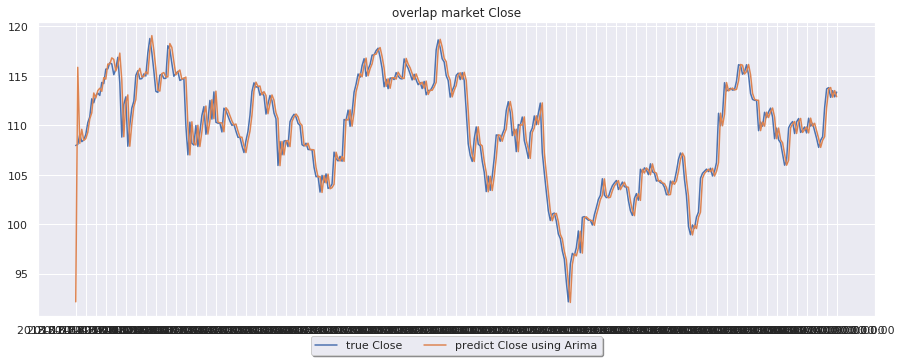

In [ ]:
pred_arima = best_arima.predict()
x_range = np.arange(df_log.shape[0])
fig = plt.figure(figsize = (15,6))
ax = plt.subplot(111)
ax.plot(x_range, reverse_close(df_log.iloc[:,3].values), label = 'true Close')
ax.plot(x_range, reverse_close(pred_arima), label = 'predict Close using Arima')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.xticks(x_range[::5], date_ori[::5])
plt.title('overlap market Close')
plt.show()

In [ ]:
boundary = (thought_vector.shape[0] // timestamp) * timestamp
stack_predict = np.vstack([pred_arima[:boundary], output_predict.reshape((-1))]).T

In [ ]:
where_below_0 = np.where(stack_predict < 0)
where_higher_1 = np.where(stack_predict > 1)
stack_predict[where_below_0[0], where_below_0[1]] = 0
stack_predict[where_higher_1[0], where_higher_1[1]] = 1

In [ ]:
corr_df = pd.DataFrame(np.hstack([stack_predict, df_log.values[:boundary, 3].reshape((-1,1))]))

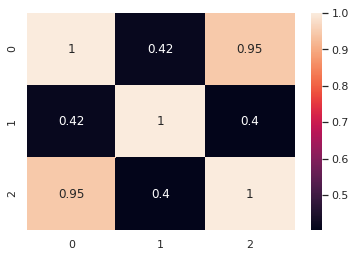

In [ ]:
sns.heatmap(corr_df.corr(), annot= True)
plt.show()

ARIMA able to predict data that correlate 0.95 originally from original Close

Deep Recurrent Neural Network able to predict data that correlate 0.72 originally from original Close

In [ ]:
import xgboost as xgb

In [ ]:
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = df_log.values[:boundary, 3]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict,train_Y, eval_set=[(stack_predict,train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
stacked = clf.predict(stack_predict)

In [ ]:
plt.figure(figsize = (15,6))
x_range = np.arange(boundary)
plt.plot(x_range, reverse_close(train_Y), label = 'Real Close')
plt.plot(x_range, reverse_close(pred_arima[:boundary]), label = 'ARIMA Close')
plt.plot(x_range, reverse_close(output_predict), label = 'RNN Close')
plt.plot(x_range, reverse_close(stacked), label = 'Stacked Close')
plt.legend()
plt.xticks(x_range[::5], date_ori[:boundary][::5])
plt.title('stacked RNN + ARIMA with XGB')
plt.show()

In [ ]:
### Arima Slightly more important than RNN, but clearly overfits (most likley represents lagged close more than anything else)
from xgboost import plot_importance
plot_importance(clf)
plt.show()